In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Load Datasets

In [2]:
info = []
train_pairs = []
test_pairs = []

for i in [1, 2]:
    info.append( pd.read_csv('data/info_{}.csv'.format(i), index_col=0) )
    
    train_df = pd.read_csv('data/train_{}.csv'.format(i), header=None)
    train_pairs.append( (  train_df.iloc[:, :-1], train_df.iloc[:, -1]  ) )
    
    test_df = pd.read_csv('data/test_with_label_{}.csv'.format(i), header=None)
    test_pairs.append( (  test_df.iloc[:, :-1], test_df.iloc[:, -1]  ) )

# define index constants
X, y = range(2)
ds1, ds2 = range(2)

Train, Test, Validate

In [3]:
per = [Perceptron().fit(*train) for train in train_pairs]
pred_values = list(range(2))
for i, (model, test) in enumerate(zip(per, test_pairs)):
    ds = 'DS{}'.format(i+1)
    pred_values[i] = pd.Series(model.predict(test[X]))
    pred_values[i].to_csv('output/PER-DS{}.csv'.format(i+1), header=None)

Confusion Matrix and Plot

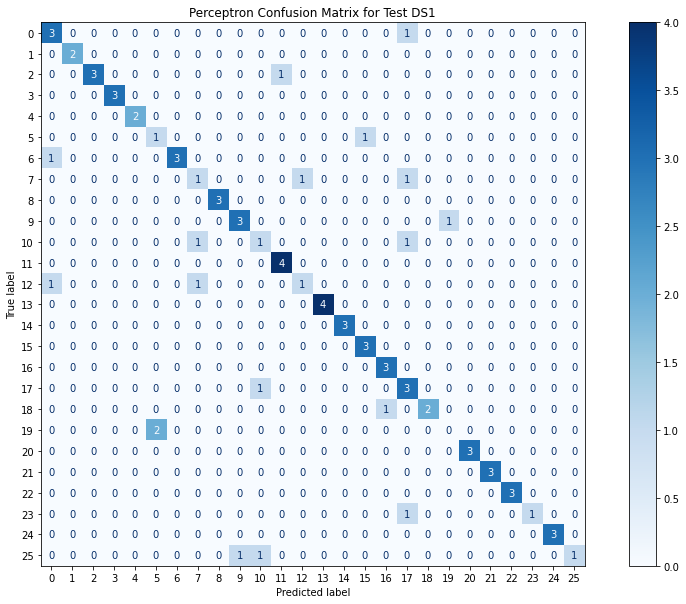

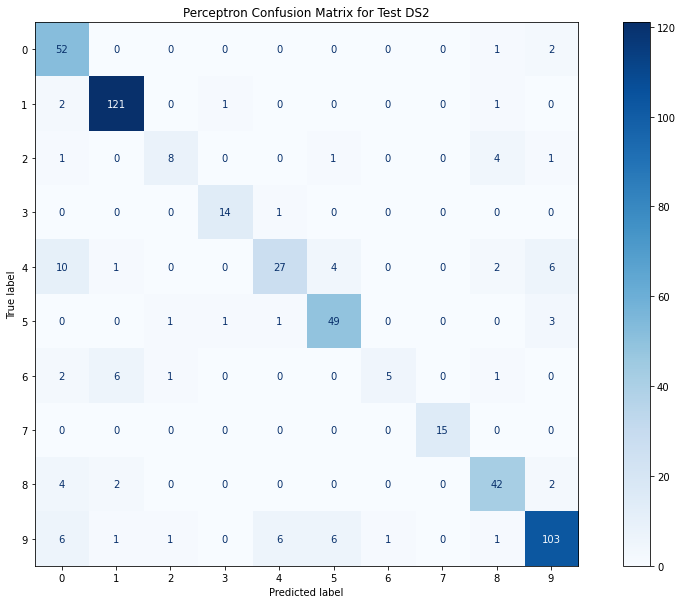

In [4]:
cm = [confusion_matrix(test[y], y_pred) for test, y_pred in zip(test_pairs, pred_values)]

# show and save confusion matrix plot
for i, (model, test) in enumerate(zip(per, test_pairs)):
    ds = 'DS{}'.format(i+1)
    fig, ax = plt.subplots(figsize=(16,10))
    plot_confusion_matrix(model, *test, cmap='Blues', ax=ax)
    ax.set_title('Perceptron Confusion Matrix for Test {}'.format(ds))
    plt.savefig('img/PER_confusion_matrix_{}'.format(ds))
    plt.show()

Compute Metrics for Each Class

In [5]:
def compute_metrics(df, y_true, y_pred):
    df_metrics = pd.DataFrame(sklearn.metrics.classification_report(y_true, y_pred, target_names=df['symbol'], output_dict=True)).T
    df_metrics['symbol'] = df_metrics.index
    df_metrics
    return pd.merge(df, df_metrics, how='right')

for i, (test, y_pred) in enumerate(zip(test_pairs, pred_values)):
    ds = 'DS{}'.format(i+1)
    info[i] = compute_metrics(info[i], test[y], y_pred)
    info[i].to_csv('output/PER-{}.csv'.format(ds), mode='a')

Accuracy, Macro-Average F1 and Weighted-Average F1 of the Model

In [6]:
def compute_scores(y_test, y_pred):
    return [
        sklearn.metrics.accuracy_score(y_test, y_pred),
        sklearn.metrics.f1_score(y_test, y_pred, average='macro'),
        sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    ]

model_desc = pd.DataFrame(index=['accuracy', 'macro-average-f1', 'weighted-average-f1'])

for i, (test, y_pred) in enumerate(zip(test_pairs, pred_values)):
    ds = 'DS{}'.format(i+1)
    model_desc[ds] = compute_scores(test[y], y_pred)
    model_desc[ds].to_frame().T.to_csv('output/PER-{}.csv'.format(ds), mode='a')